In [1]:
import os
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
from tensorflow import keras
from tensorflow.keras import layers


/home/user/anaconda3/envs/tf/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [10]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [3]:
rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__ ):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state



In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


class Attention(keras.Model):
    def __init__(self, input_dim, var_scope, reuse=True):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        with tf.compat.v1.variable_scope(var_scope, reuse=reuse):
            self.attention_w = layers.Dense(self.input_dim, name='W')
            self.attention_u = layers.Dense(self.input_dim, name='U')
            self.attention_v = layers.Dense(1, name='V')

    def call(self, input_x, prev_state_tuple):
        """
        Compute the attention weight for input series
        hidden_state, cell_state (batch_size, hidden_dim)
        input_x (batch_size, num_series, input_dim),
        input_dim = num_steps for input attention
        """
        prev_hidden_state, prev_cell_state = prev_state_tuple

        # (batch_size, 1, hidden_dim * 2)
        concat_state = tf.expand_dims(tf.concat([prev_hidden_state, prev_cell_state], axis=-1),
                                      axis=1)

        # (batch_size, num_series, input_dim)
        score_ = self.attention_w(concat_state) + self.attention_u(input_x)

        # (batch_size, num_series, 1)
        # Equation (8)
        score = self.attention_v(tf.nn.tanh(score_))

        # (batch_size, num_series)
        # Equation (9)
        weight = tf.squeeze(tf.nn.softmax(score, axis=1), axis=-1)

        return weight


class LSTMCell(keras.Model):
    def __init__(self, hidden_dim):
        super(LSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_fc = layers.Dense(self.hidden_dim)

    def call(self, input_x, prev_state_tuple):
        """ Return next step's hidden state and cell state  """
        hidden_state, cell_state = prev_state_tuple

        # (batch_size, hidden_dim + input_dim)
        concat_input = tf.concat([hidden_state, input_x], axis=-1)

        # (batch_size * 4, hidden_dim + input_dim)
        concat_input_tiled = tf.tile(concat_input, [4, 1])

        # Equation (3) - (6) without activation
        forget_, input_, output_, cell_bar = tf.split(self.layer_fc(concat_input_tiled),
                                                      axis=0,
                                                      num_or_size_splits=4)

        # (batch_size, hidden_dim)
        # Equation (6)
        cell_state = tf.nn.sigmoid(forget_) * cell_state + \
                     tf.nn.sigmoid(input_) * tf.nn.tanh(cell_bar)

        # Equation (7)
        hidden_state = tf.nn.sigmoid(output_) * tf.nn.tanh(cell_state)
        return (hidden_state, cell_state)


class Encoder(keras.Model):
    def __init__(self, encoder_dim, num_steps):
        super(Encoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_layer = Attention(num_steps, var_scope='input_attention')
        self.lstm_cell = LSTMCell(encoder_dim)

    def call(self, inputs):
        """
        inputs: (batch_size, num_steps, num_series)
        """


        def one_step(prev_state_tuple, current_input):
            """ Move along the time axis by one step  """

            # (batch_size, num_series, num_steps)
            inputs_scan = tf.transpose(inputs, perm=[0, 2, 1])

            # (batch_size, num_series)
            weight = self.attention_layer(inputs_scan, prev_state_tuple)

            weighted_current_input = weight * current_input

            return self.lstm_cell(weighted_current_input, prev_state_tuple)

        # Get the batch size from inputs
        self.batch_size = tf.shape(inputs)[0]
        self.num_steps = inputs.get_shape().as_list()[1]

        self.init_hidden_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])
        self.init_cell_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(inputs, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple = tf.scan(one_step,
                              elems=inputs_,
                              initializer=(self.init_hidden_state,
                                           self.init_cell_state))

        # (batch_size, num_steps, encoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])
        return all_hidden_state


class Decoder(keras.Model):
    def __init__(self, decoder_dim, num_steps):
        super(Decoder, self).__init__()
        self.decoder_dim = decoder_dim
        self.attention_layer = Attention(num_steps, var_scope='temporal_attention')
        self.lstm_cell = LSTMCell(decoder_dim)
        self.layer_fc_context = layers.Dense(1)
        self.layer_prediction_fc_1 = layers.Dense(decoder_dim)
        self.layer_prediction_fc_2 = layers.Dense(decoder_dim/2)
        self.layer_prediction_fc_3 = layers.Dense(1)

    def call(self, encoder_states, inputs, labels):
        """
        encoder_states: (batch_size, num_steps, encoder_dim)
        labels: (batch_size, num_steps)
        """

        def one_step(accumulator, current_label):
            """ Move along the time axis by one step  """
            #inputs_scan2 = tf.transpose(inputs, perm=[0, 2, 1])
            
            prev_state_tuple, context = accumulator
            # (batch_size, num_steps)
            # Equation (12) (13)
            print("inputs : " , inputs )
            weight = self.attention_layer(inputs, prev_state_tuple)
            print("weight : " , weight )

            # Equation (14)
            # (batch_size, encoder_dim)
            print("encoder_states : " , encoder_states)
            context = tf.reduce_sum(tf.expand_dims(weight, axis=-1) * encoder_states,
                                    axis=1)

            # Equation (15)
            # (batch_size, 1)
            y_tilde = self.layer_fc_context(tf.concat([current_label, context], axis=-1))

            # Equation (16)
            return self.lstm_cell(y_tilde, prev_state_tuple), context

        # Get the batch size from inputs
        self.batch_size = tf.shape(encoder_states)[0]
        self.num_steps = encoder_states.get_shape().as_list()[1]
        self.encoder_dim = encoder_states.get_shape().as_list()[-1]

        init_hidden_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_cell_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_context = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(encoder_states, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple, all_context = tf.scan(one_step,
                                           elems=inputs_,
                                           initializer=((init_hidden_state,
                                                        init_cell_state),
                                                        init_context))

        # (batch_size, num_steps, decoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])

        # (batch_size, num_steps, encoder_dim)
        all_context = tf.transpose(all_context, perm=[1, 0, 2])

        last_hidden_state = all_hidden_state[:, -1, :]
        last_context = all_context[:, -1, :]

        # (batch_size, 1)
        # Equation (22)
        pred_ = self.layer_prediction_fc_1(tf.concat([last_hidden_state, last_context], axis=-1))
        pred__ = self.layer_prediction_fc_2(pred_)
        pred= self.layer_prediction_fc_3(pred__)

        return pred

In [5]:
class DARNN():
    def __init__(self,  num_series, encoder_dim, decoder_dim, num_steps, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        encoder_steps=num_steps+1
        self.encoder = Encoder(encoder_dim, encoder_steps)

        self.decoder = Decoder(decoder_dim, num_steps)
    def __call__(self, X_history, y_history):
        out =self.decoder(self.encoder(X_history),X_history, y_history) 
        #TemporalAttentionDecoder.forward(id(self.decoder),InputAttentionEncoder.forward(id(self.encoder),X_history), X_history,y_history)
        return out 

In [6]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
       
        #tf. compat.v1.reset_default_graph()
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
        print("result = " , result)

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
        print("LSTM2 = " , LSTM2)
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
        print("Y_2 = " , Y_2.shape)

        #Attention_Layer
        
        
        model = DARNN(64, 64, 64, self.T) 
        y_pred = model(Y_2, self.Y) 
        print("y_pred : " , y_pred )
        #y_pred = tf.squeeze(y_pred)
        #print("y_pred : " , y_pred )

        #Non-linear units for producing final prediction.
       

        self.out=y_pred
        #self.out=Y_2
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)
    


    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'NASDAQ/Sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

IndexPrice shape:  (3000, 1)


KeyboardInterrupt: 

In [19]:
512/8

64.0

In [10]:
import os
os.getcwd()

'/home/user/Desktop/MI-LSTM-master'

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
    
for i in range(30):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))


IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7fe53d94b350>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 16, 64)
Ple

0.8259276915341616
0.27595630032010376
epoch : 12, t_cost : 0.007942, e_cost : 0.006272, elapsed time : 18.22sec
(53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
0.9920226528774947
0.1758148712106049
epoch : 13, t_cost : 0.009539, e_cost : 0.003996, elapsed time : 18.20sec
(53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
0.818804943934083
0.1369377807714045
epoch : 14, t_cost : 0.007873, e_cost : 0.003112, elapsed time : 18.23sec
(53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 10, 16, 1) (23010, 10, 16, 1) (23010, 16, 1) (23010, 1)
0.7390885669738054
0.12561845814343542
epoch : 15, t_cost : 0.007107, e_cost : 0.002855, elapsed time : 18.26sec
(53690, 16, 1) (53690, 10, 16, 1) (53690, 10, 16, 1) (53690, 16, 1) (53690, 1

## epoch : 10 , batchsize : 512 , timesize : 4

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
    
for i in range(10):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))


IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 4, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7fd51c90b5d0>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 4, 64)
Pleas

## epoch : 100 , batchsize : 256 , timesize : 8

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=8
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))


IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 8, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f6e3428cd90>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 8, 64)
Pleas

(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.5356677894014865
0.25270630681188777
epoch : 13, t_cost : 0.002563, e_cost : 0.002839, elapsed time : 18.71sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.497914171370212
0.23329754313454032
epoch : 14, t_cost : 0.002382, e_cost : 0.002621, elapsed time : 18.85sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.4722733865492046
0.21033889742102474
epoch : 15, t_cost : 0.002260, e_cost : 0.002363, elapsed time : 18.78sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.44889040966518223
0.19472274906001985
epoch : 16, t_cost : 0.002148, e_cost : 0.002188, elapsed time : 18.62sec
(53690, 8, 1) (53690, 1

0.3030695367488079
0.10263928840868175
epoch : 44, t_cost : 0.001450, e_cost : 0.001153, elapsed time : 18.57sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.3018388344789855
0.10306061952724122
epoch : 45, t_cost : 0.001444, e_cost : 0.001158, elapsed time : 18.58sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.30384274272364564
0.10224196963827126
epoch : 46, t_cost : 0.001454, e_cost : 0.001149, elapsed time : 18.58sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.30384844285435975
0.10405948117841035
epoch : 47, t_cost : 0.001454, e_cost : 0.001169, elapsed time : 18.57sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010,

(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.2811375454766676
0.09797323847305961
epoch : 76, t_cost : 0.001345, e_cost : 0.001101, elapsed time : 18.55sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.28091360718826763
0.09880320084630512
epoch : 77, t_cost : 0.001344, e_cost : 0.001110, elapsed time : 18.57sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.2809715959301684
0.09949172881897539
epoch : 78, t_cost : 0.001344, e_cost : 0.001118, elapsed time : 18.56sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.2805501098919194
0.09887804568279535
epoch : 79, t_cost : 0.001342, e_cost : 0.001111, elapsed time : 18.65sec
(53690, 8, 1) (53690, 

## eopch : 100 , batchsize : 512 , timesize : 8

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=8
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))


IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 8, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f62de5b5bd0>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 8, 64)
Pleas

(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.5804583670105785
0.3199927171226591
epoch : 13, t_cost : 0.005581, e_cost : 0.007273, elapsed time : 9.42sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.5764026711694896
0.22586331865750253
epoch : 14, t_cost : 0.005542, e_cost : 0.005133, elapsed time : 9.45sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.5702748560579494
0.3035547441104427
epoch : 15, t_cost : 0.005483, e_cost : 0.006899, elapsed time : 9.47sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.5656875588465482
0.25106361717917025
epoch : 16, t_cost : 0.005439, e_cost : 0.005706, elapsed time : 9.44sec
(53690, 8, 1) (53690, 10, 8, 

0.2761421106988564
0.06257233288488351
epoch : 44, t_cost : 0.002655, e_cost : 0.001422, elapsed time : 9.44sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.2755812321556732
0.06397095185820945
epoch : 45, t_cost : 0.002650, e_cost : 0.001454, elapsed time : 9.45sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.268825072911568
0.062340605683857575
epoch : 46, t_cost : 0.002585, e_cost : 0.001417, elapsed time : 9.45sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.2633218531263992
0.06518709822557867
epoch : 47, t_cost : 0.002532, e_cost : 0.001482, elapsed time : 9.44sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8

(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.35370497085386887
0.0613510258262977
epoch : 76, t_cost : 0.003401, e_cost : 0.001394, elapsed time : 9.43sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.32816650142194703
0.05711613496532664
epoch : 77, t_cost : 0.003155, e_cost : 0.001298, elapsed time : 9.43sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.24558835965581238
0.0530881259473972
epoch : 78, t_cost : 0.002361, e_cost : 0.001207, elapsed time : 9.46sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.20463626214768738
0.05097543858573772
epoch : 79, t_cost : 0.001968, e_cost : 0.001159, elapsed time : 9.42sec
(53690, 8, 1) (53690, 10,

## eopch : 100 , batchsize : 512 , timesize : 8

result =  Tensor("concat:0", shape=(None, 8, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f60d6a1a790>
Y_2 =  (None, 8, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f60d70f7190>, <gast.gast.Return object at 0x7f60d70f7310>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f60d70f7190>, <gast.gast.Return object at 0x7f60d70f7310>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 8, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 8), dtype=float32)
encoder_states :  Tensor("encoder/transpose_1:0", shape=(None, 8, 64), dtype=float32)
Please report thi

(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
1.0387381406035274
0.10763660876546055
epoch : 23, t_cost : 0.009988, e_cost : 0.002446, elapsed time : 9.48sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.7159219569293782
0.09738499007653445
epoch : 24, t_cost : 0.006884, e_cost : 0.002213, elapsed time : 9.47sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.7751162484637462
0.10244039486860856
epoch : 25, t_cost : 0.007453, e_cost : 0.002328, elapsed time : 9.48sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.6339620883809403
0.09593054134165868
epoch : 26, t_cost : 0.006096, e_cost : 0.002180, elapsed time : 9.46sec
(53690, 8, 1) (53690, 10, 8

0.28975150239421055
0.0674635595350992
epoch : 54, t_cost : 0.002786, e_cost : 0.001533, elapsed time : 9.49sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.2850285260938108
0.07511035786592402
epoch : 55, t_cost : 0.002741, e_cost : 0.001707, elapsed time : 9.48sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.27540589758427814
0.07587430335115641
epoch : 56, t_cost : 0.002648, e_cost : 0.001724, elapsed time : 9.45sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.27208891068585217
0.07817391864955425
epoch : 57, t_cost : 0.002616, e_cost : 0.001777, elapsed time : 9.48sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10,

(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.20062077266629785
0.04627612858894281
epoch : 86, t_cost : 0.001929, e_cost : 0.001052, elapsed time : 9.47sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.20402190659660846
0.045898621290689334
epoch : 87, t_cost : 0.001962, e_cost : 0.001043, elapsed time : 9.50sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.22224316885694861
0.046465438994346187
epoch : 88, t_cost : 0.002137, e_cost : 0.001056, elapsed time : 9.49sec
(53690, 8, 1) (53690, 10, 8, 1) (53690, 10, 8, 1) (53690, 8, 1) (53690, 1)
(23010, 8, 1) (23010, 10, 8, 1) (23010, 10, 8, 1) (23010, 8, 1) (23010, 1)
0.22022037947317585
0.04751899096299894
epoch : 89, t_cost : 0.002118, e_cost : 0.001080, elapsed time : 9.48sec
(53690, 8, 1) (53690,

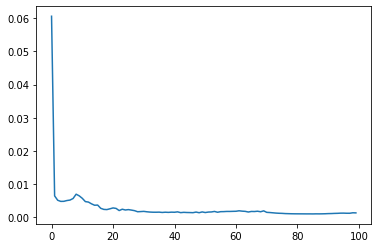

In [21]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=8
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512

'''
kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)
'''

lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

0.013394969479784117

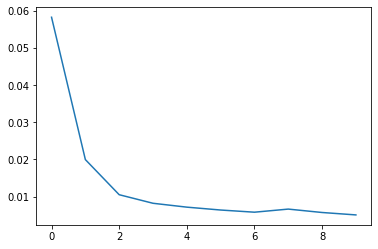

In [20]:
import matplotlib.pyplot as plt
print(plt.plot(evalution_costplt))
np.mean(evalution_costplt)

## eopch : 100 , batchsize : 512 , timesize : 16

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512

kospi=StockData(
    'NASDAQ/Sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt1=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt1.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt1))

IndexPrice shape:  (40559, 1)
StockPrice shape:  (40559, 81)
making dataset progress : finished	59
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f92293f4650>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 16, 64)

(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.5239475618213874
37.21703594415885
epoch : 12, t_cost : 0.000117, e_cost : 0.019364, elapsed time : 792.17sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.5029574775462606
36.853362598521926
epoch : 13, t_cost : 0.000112, e_cost : 0.019174, elapsed time : 792.54sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.4926622333341584
38.78091352645424
epoch : 14, t_cost : 0.000110, e_cost : 0.020177, elapsed time : 792.32sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1)

(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.3726765529822842
41.67431798137477
epoch : 41, t_cost : 0.000083, e_cost : 0.021683, elapsed time : 791.56sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.3739610250459009
61.66110813725754
epoch : 42, t_cost : 0.000083, e_cost : 0.032082, elapsed time : 791.57sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.37230337325763685
43.44507636173512
epoch : 43, t_cost : 0.000083, e_cost : 0.022604, elapsed time : 792.33sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1)

(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.34553688062351284
27.17106843250076
epoch : 70, t_cost : 0.000077, e_cost : 0.014137, elapsed time : 792.43sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.34637403133820044
26.546916076789785
epoch : 71, t_cost : 0.000077, e_cost : 0.013812, elapsed time : 792.31sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.3460332729878246
17.998729048849782
epoch : 72, t_cost : 0.000077, e_cost : 0.009365, elapsed time : 792.28sec
(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16,

(2296860, 16, 1) (2296860, 10, 16, 1) (2296860, 10, 16, 1) (2296860, 16, 1) (2296860, 1)
(984369, 16, 1) (984369, 10, 16, 1) (984369, 10, 16, 1) (984369, 16, 1) (984369, 1)
0.3363704316930125
15.375081258451246
epoch : 99, t_cost : 0.000075, e_cost : 0.008000, elapsed time : 792.31sec

#Best result at epoch 99
t_cost : 0.000075, e_cost : 0.008000


NameError: name 'plt' is not defined

0.02191540688550784

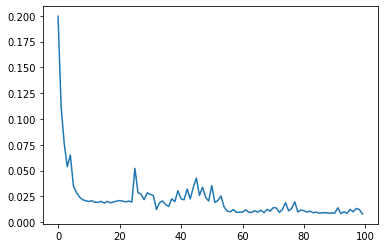

In [8]:
import matplotlib.pyplot as plt
print(plt.plot(evalution_costplt1))
np.mean(evalution_costplt1)

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'NASDAQ/Sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
    
for i in range(1000):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))

## eopch : 100 , batchsize : 512 , timesize : 32

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f921f7e1310>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f921f5116d0>, <gast.gast.Return object at 0x7f921f511750>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f921f5116d0>, <gast.gast.Return object at 0x7f921f511750>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.6724826460704207
0.11072315939236432
epoch : 22, t_cost : 0.006466, e_cost : 0.002516, elapsed time : 37.26sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.585311686154455
0.10085484106093645
epoch : 23, t_cost : 0.005628, e_cost : 0.002292, elapsed time : 37.20sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.5235603409819305
0.08911015396006405
epoch : 24, t_cost : 0.005034, e_cost : 0.002025, elapsed time : 37.21sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.5322883308399469
0.08514223020756617
epoch : 25, t_cost : 0.005118, e_cost : 0.001935, elapsed time : 37.16

0.3308872290654108
0.06399725752999075
epoch : 52, t_cost : 0.003182, e_cost : 0.001454, elapsed time : 37.21sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.3417848020908423
0.05577737360727042
epoch : 53, t_cost : 0.003286, e_cost : 0.001268, elapsed time : 37.17sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2928307466208935
0.055489502381533384
epoch : 54, t_cost : 0.002816, e_cost : 0.001261, elapsed time : 37.22sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.31534330308204517
0.05579029268119484
epoch : 55, t_cost : 0.003032, e_cost : 0.001268, elapsed time : 37.20sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (536

(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.17520320077892393
0.05884537196834572
epoch : 83, t_cost : 0.001685, e_cost : 0.001337, elapsed time : 37.17sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.18674771103542298
0.06379547453252599
epoch : 84, t_cost : 0.001796, e_cost : 0.001450, elapsed time : 37.14sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.19501330243656412
0.06581732747144997
epoch : 85, t_cost : 0.001875, e_cost : 0.001496, elapsed time : 37.08sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.20483122498262674
0.07438898287364282
epoch : 86, t_cost : 0.001970, e_cost : 0.001691, elapsed time : 

0.002795698191852848

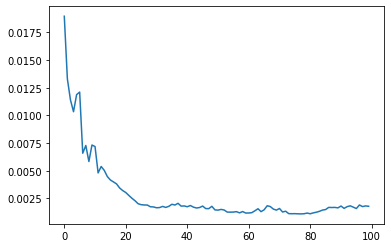

In [11]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt2=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt2.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt2))
np.mean(evalution_costplt2)

## eopch : 100 , batchsize : 256 , timesize : 32